In [1]:
import numpy as np
import tensorflow as tf 
import time
from Utils import *

In [4]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

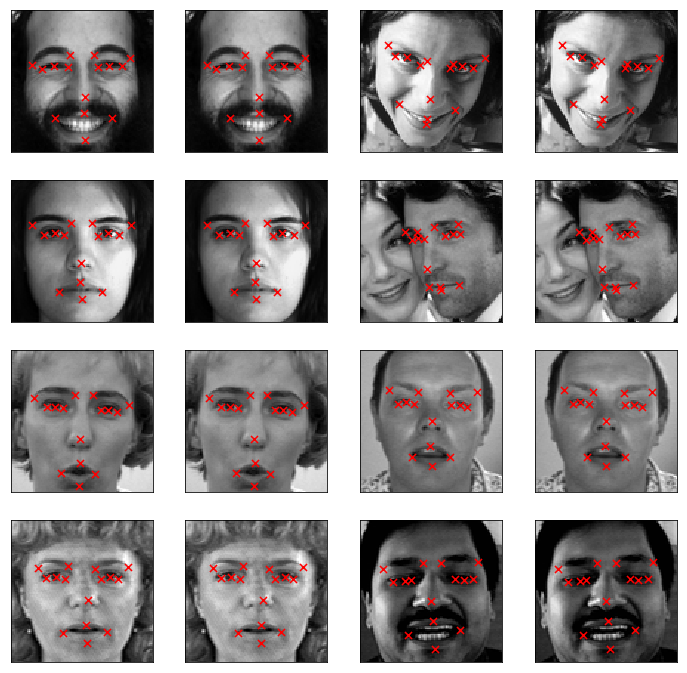

In [5]:
import matplotlib.pyplot as pyplot

fig = pyplot.figure(figsize=(12, 12))

for i in range(8):
    ax = fig.add_subplot(4, 4, i*2 + 1, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax)
    
    ax2 = fig.add_subplot(4, 4, i*2 + 2, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax2)

pyplot.show()

In [10]:
train_graph = tf.Graph()
with train_graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 9216))
    labels = tf.placeholder(tf.float32, shape=(None, 30))
    
    input_layer = tf.reshape(images, [-1, 96, 96, 1])
    
    with tf.name_scope("conv1"):
            conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu
        )
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
            
    with tf.name_scope("conv2"):
            conv1 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[2, 2],
            padding="same",
            activation=tf.nn.relu
        )
            pool2 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
            
    with tf.name_scope("conv3"):
            conv1 = tf.layers.conv2d(
            inputs=pool2,
            filters=128,
            kernel_size=[2, 2],
            padding="same",
            activation=tf.nn.relu
        )
            pool3 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
            
    with tf.name_scope("hideen4"):
        flat = tf.reshape(pool3, [-1, 12 * 12 * 128])
        dense = tf.layers.dense(inputs=flat, units=512, activation=tf.nn.relu)
        
#         hidden4 = tf.layers.dropout(inputs=dense, rate=0.4, training=training)
        
    output = tf.layers.dense(inputs=dense, units=30)
    
    loss = tf.losses.mean_squared_error(labels, output)
    
    tf.summary.scalar("loss", loss)
    global_step = tf.Variable(0, name="global_step", trainable=False)
    
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=global_step)

In [12]:
model_save_dir = "./facial_point_detection/"
model_name = '1'

training_writer_path  = model_save_dir + 'train-' + model_name
validation_writer_path = model_save_dir + 'validation-' + model_name

train_writer = tf.summary.FileWriter(logdir=training_writer_path, flush_secs=3)
validatin_writer = tf.summary.FileWriter(logdir=validation_writer_path, flush_secs=3)

In [14]:
ratio_validation = 0.2
num_validation = int(X.shape[0] * ratio_validation)

X_train = X[num_validation:, :]
y_train = y[num_validation:, :]

X_validation = X[:num_validation, :]
y_validation = y[:num_validation, :]

batch_size = 64
num_batch = int(X_train.shape[0]/batch_size)+1

In [26]:
num_epoch = 100

model_path = model_save_dir + 'model-' + model_name + '/'
checkpoint_path = model_path + 'model.ckpt'
    
with tf.Session(graph=train_graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)  
    
    saver = tf.train.Saver(tf.global_variables())
    last = tf.train.latest_checkpoint(model_path)
    if last:
        saver.restore(sess, last)
        print('load model from {}'.format(last))
        
    train_writer.graph=train_graph
    validatin_writer.graph=train_graph
            
    for e in range(num_epoch):        
        for b in range(num_batch):
            start = time.time()

            current_idx = batch_size * b
            next_idx = current_idx + batch_size
        
            X_train_batch = X_train[current_idx:next_idx, :]
            y_train_batch = y_train[current_idx:next_idx, :]
    
            feed_dict_train = {images: X_train_batch, labels: y_train_batch}  
            feed_dict_validation = {images: X_validation, labels: y_validation}

            sess.run(train_op, feed_dict=feed_dict_train)
            
            global_step_num = sess.run(global_step)

            elapsed = time.time() - start

            if (global_step_num % 10) == 0:
                    train_loss_summary, train_loss = sess.run([loss_summary, loss], feed_dict=feed_dict_train)
                    validation_loss_summary, validation_loss = sess.run([loss_summary, loss], feed_dict=feed_dict_validation)
                    train_writer.add_summary(train_loss_summary, global_step=global_step_num)
                    validatin_writer.add_summary(validation_loss_summary, global_step=global_step_num)
                    print("Step: {:4d}\tValidation Loss: {:.7f}\tTime/Batch: {:.3f}".format(global_step_num, validation_loss, elapsed))

            if (global_step_num % 10) == 0:
                saver.save(sess, checkpoint_path, global_step=global_step_num)    
                print("model saved to {}".format(model_path))

INFO:tensorflow:Restoring parameters from ./facial_point_detection/model-1/model.ckpt-100
load model from ./facial_point_detection/model-1/model.ckpt-100
Step:  110	Validation Loss: 0.0027455	Time/Batch: 0.519
model saved to ./facial_point_detection/model-1/
Step:  120	Validation Loss: 0.0024763	Time/Batch: 0.622
model saved to ./facial_point_detection/model-1/
Step:  130	Validation Loss: 0.0023931	Time/Batch: 0.580
model saved to ./facial_point_detection/model-1/
Step:  140	Validation Loss: 0.0021604	Time/Batch: 0.544
model saved to ./facial_point_detection/model-1/
Step:  150	Validation Loss: 0.0020390	Time/Batch: 0.523
model saved to ./facial_point_detection/model-1/
Step:  160	Validation Loss: 0.0019577	Time/Batch: 0.570
model saved to ./facial_point_detection/model-1/
Step:  170	Validation Loss: 0.0018613	Time/Batch: 0.573
model saved to ./facial_point_detection/model-1/
Step:  180	Validation Loss: 0.0018232	Time/Batch: 0.484
model saved to ./facial_point_detection/model-1/
Step: 

KeyboardInterrupt: 

!tensorboard --logdir=./facial_point_detection

In [27]:
model_name ='1'
load_model_path = model_save_dir + 'model-' + model_name

with tf.Session(graph=train_graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)  
    
    saver = tf.train.Saver()

    last = tf.train.latest_checkpoint(load_model_path)
    if last:
        saver.restore(sess, last)
            
    feed_dict_validation = {images: X_validation, labels: y_validation}
        
    y_prediction = sess.run(output, feed_dict = feed_dict_validation)

INFO:tensorflow:Restoring parameters from ./facial_point_detection/model-1/model.ckpt-260


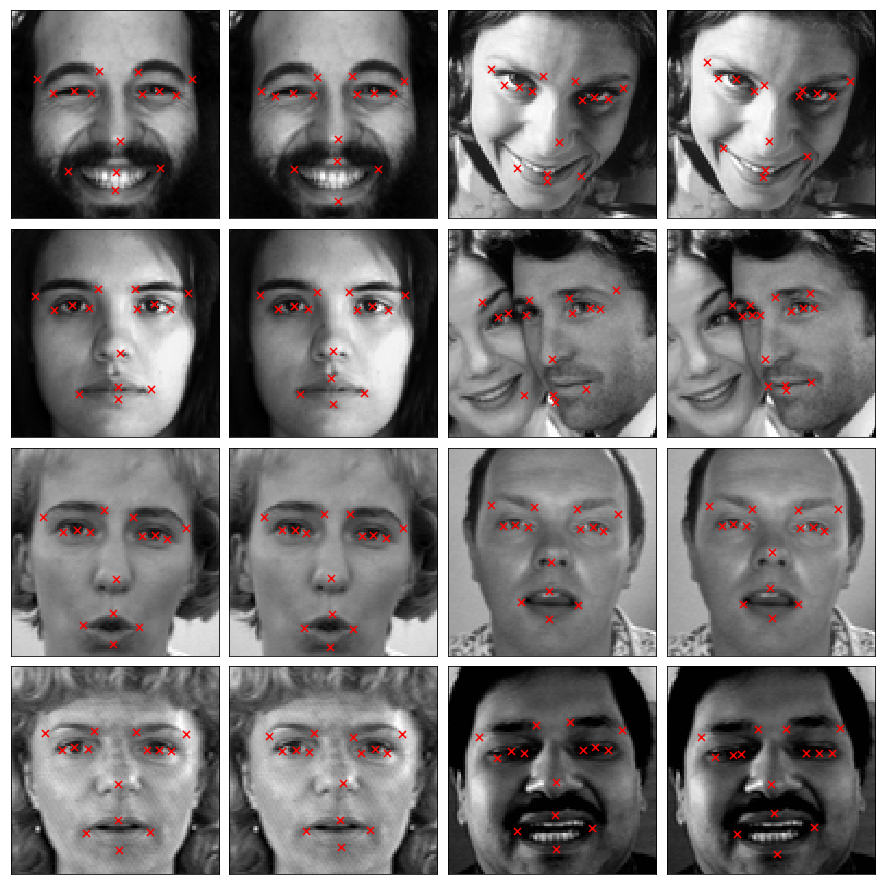

In [28]:
import matplotlib.pyplot as pyplot

fig = pyplot.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(4, 4, i*2 + 1, xticks=[], yticks=[])
    plot_sample(X_validation[i], y_prediction[i], ax)
    
    ax2 = fig.add_subplot(4, 4, i*2 + 2, xticks=[], yticks=[])
    plot_sample(X_validation[i], y_validation[i], ax2)

pyplot.show()